# Making an MLP Front To Back

* [ ] Figure out why grad_y_batch works and specifically in relation to lsm
* [ ] Develop clean API for layers and models

In [1]:
import numpy as np
import tqdm
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

# Setting plot styles
sns.set_style('white')
mpl.rcParams.update({
    'font.size': 14,
    'lines.linewidth': 2,
    'figure.figsize': (6, 6 / 1.61)
})
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['lines.marker'] = None
mpl.rcParams['axes.grid'] = True

DEFAULT_FONTSIZE = 13
mpl.rcParams.update({
    'font.size': DEFAULT_FONTSIZE,
    'lines.linewidth': 2,
    'legend.fontsize': DEFAULT_FONTSIZE,
    'axes.labelsize': DEFAULT_FONTSIZE,
    'xtick.labelsize': DEFAULT_FONTSIZE,
    'ytick.labelsize': DEFAULT_FONTSIZE,
    'figure.figsize': (7, 7.0 / 1.4)
})
K = keras.backend

# Setting random seeds
import os
seed_value = 0
os.environ['PYTHONHASHSEED'] = str(seed_value)
seed_value += 1

# Random module
import random
random.seed(seed_value)
seed_value += 1

# Numpy random seed
np.random.seed(seed_value)
seed_value += 1

# Tensorflow seed
tf.random.set_seed(seed_value)

# All my homies hate scientific notation
np.set_printoptions(suppress=True)

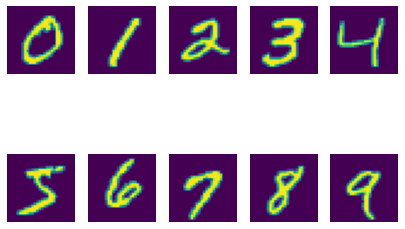

In [23]:
# PLotting each of the ten digits
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = (X_train / 255.).astype(np.float32)
y_train = y_train

fig, axes = plt.subplots(2, 5)
axes = axes.ravel()

inds = []
for y in range(10):
    inds.append(np.argmax(y == y_train))
ten_digits = X_train[inds]

for digit, ax in zip(ten_digits, axes):
    ax.grid('off')
    ax.axis('off')
    ax.imshow(digit, cmap='viridis')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


Epoch 1/1:: 100%|██████████| 1875/1875 [00:12<00:00, 150.77it/s, accuracy=0.938, loss=0.371]


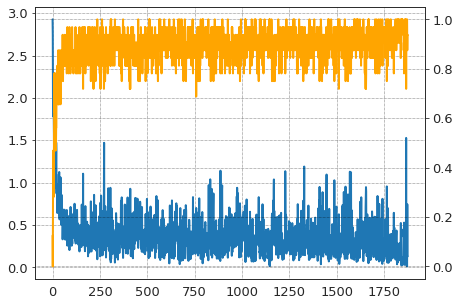

In [33]:
# Writing custom training loop
K.clear_session()
tf.random.set_seed(42)

def make_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=X_train[0].shape))
    model.add(keras.layers.Dense(64, kernel_initializer='he_normal'))
    model.add(keras.layers.Dense(64, kernel_initializer='he_normal'))
    model.add(keras.layers.Dense(10, kernel_initializer='he_normal', activation='softmax'))
    return model

# Batching dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE
dset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(AUTOTUNE)

# Training parameters
train_size = X_train.shape[0]
batch_size = 32
epochs = 1
steps = np.ceil(train_size / batch_size).astype(int)
current_loss = 1000

# Initialize model
model = make_model()
model.summary()
time.sleep(1)

# Optimizer and loss function
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.SGD(lr=0.05)

# Metrics
mean_loss = keras.metrics.Mean()
acc = keras.metrics.SparseCategoricalAccuracy(name='accuracy')

@tf.function
def compute_mnist_grad(model, loss_fn, X_batch, y_batch):
    with tf.GradientTape() as tape:
        y_pred = model(X_batch, training=True)
        loss = loss_fn(y_batch, y_pred)

    # finding gradients of loss function w.r.t model weights
    grad = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grad, model.trainable_weights))
    
    return loss, y_pred

loss_plot = []
acc_plot = []
for epoch in range(1, epochs+1):
    pbar = tqdm.tqdm(
        dset,
        position=0,
        leave=True,
        desc=f'Epoch {epoch}/{epochs}:',
        total=steps
        )
    for X_batch, y_batch in pbar:
        loss, y_pred = compute_mnist_grad(model, loss_fn, X_batch, y_batch)
        display_metrics = {}
        
        # Computing metrics
        accuracy = acc(y_batch, y_pred).numpy()
        display_metrics['accuracy'] = accuracy
            
        loss_plot.append(loss)
        acc_plot.append(accuracy)
        
        # Adding to the mean loss
        mean_loss(loss)
        loss_value = mean_loss.result().numpy()
        display_metrics['loss'] = loss_value
        pbar.set_postfix(display_metrics)
        acc.reset_states()
    mean_loss.reset_states()
    
plt.plot(loss_plot)
plt.twinx()
plt.plot(acc_plot, color='orange')

In [34]:
(np.argmax(model(X_train), axis=1) == y_train).sum() / y_train.shape[0]

0.8995333333333333

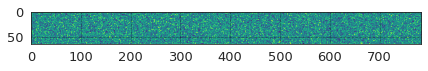

In [195]:
# Visualzing weight matrix
l1_w = model.layers[1].weights[0].numpy().T
plt.imshow(l1_w, cmap='viridis')

### Backpropagation and Autodiff
* [U of T Autodiff](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf)
* [AriSeff Autodiff](https://www.youtube.com/watch?v=wG_nF1awSSY)
* [CS231n Backprop](https://cs231n.github.io/optimization-2/)
* [Autodiff In Machine Learning: A Survey](https://arxiv.org/abs/1502.05767)
* [CS229 Backprop](http://cs229.stanford.edu/notes2020spring/cs229-notes-deep_learning.pdf)
* [Computation Graph](http://alexminnaar.com/2018/07/14/simple-computational-graph-engine.html)

One of the core aspects of all modern deep learning frameworks is the idea of differential programming, which is
a paradigm that emphasizes being able to differentiate numeric programs using *automatic differentiation* 
(autodiff). This allows us to perform things like gradient-based optimization to fit the parameters of a neural
network efficiently and easily.

**Comparison of Differentiation Techniques**

Like we learned in high school, there are two ways that we can differentiate a given function. The first is 
*numeric differentiation* where we use finite differences to approximate the value of the derivative at a certain
value. The issue with this method is that it produces innacurate estimates as well as being very slow O(n) (need
to compute this for each individual weight). Using very small values for $h$ can also lead
to numerical stability problems.

\begin{equation}
    f^\prime(x) = \frac{f(x+h) - f(x)}{h}
\end{equation}

In [4]:
# Numeric differentiation
def numeric_diff(func, x, epsilon=0.0001):
    return (func(x+epsilon) - func(x)) / epsilon

def exponential_func(x):
    return np.exp(2*x) - x**3

numeric_diff(exponential_func, 3)

779.9373781153918

We can also use our derivative rules to perform *symbolic differentiation*. This gives us an exact expression for
the value of the derivative, however it can be slow and produce unneeded complexity in the resulting computation
(this is called expression swell where the derivative of a function can become exponentially larger such as when 
applying the product rule). This problem is exacerbated in the context of neural networks where the derivative is
computed w.r.t to many layers, making the expressions explode. The closed form solution it gives also is not
advantageous as we are only concerned with obtaining a numerical value.

\begin{align}
    f(x) &= e^{2x} - x^3\\
    f^\prime(x) &= 2e^{2x}-3x^2
\end{align}

779.8575869854702


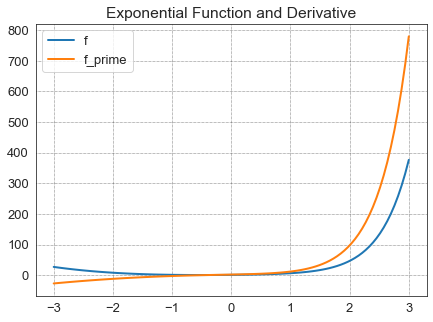

In [10]:
# Symbolic differentiation
def dx_exponential(x):
    return 2*np.exp(2*x) - 3*x**2

print(dx_exponential(3))

x = np.linspace(-3, 3, 100)
plt.plot(x, exponential_func(x), label='f')
plt.plot(x, dx_exponential(x), label='f_prime')
plt.title('Exponential Function and Derivative')
plt.legend()

**Autodiff and Why**

All these problems are fixed by using autodiff. Unlike symbolic differentiation which tries to find an expression
for the function, autodiff just finds a numerical value. It uses the idea that a numeric program consists of a
combination of some primitive operations (-, +, * etc) which we know the derivative of. 

<img src='./img/autodiff_ex.png' width='400'> </img>

There are two main forms of autodiff, the first is forward mode and the second is reverse mode.

**Forward-mode Autodiff**

**Computational Graph**

One thing when implementing autodiff and backprop is that you will need a data structure to store the intermediate
representations of each individual computation. The most common way to do this is by constructing a computational
graph where the computations are broken up into the nodes of the directed graph and feed into each other front
to back (directed acyclic graph or DAG). Below is a very simple example of breaking up a single function into
a computational graph:

<img src='./img/computation_graph_ex.png'> </img>

This simple example is exactly how the *backpropagation* algorithm works, by first computing all the outputs of
the network, storing each of them on the graph and then perform a backward pass to compute 
$\frac{\partial J}{\partial w}$ by computing the easy primitive derivatives and using the chain rule to propagate
the gradients throughout the weights in each layer.

When we calculated the derivative of f w.r.t y/x and used the chain rule the following terminology can be
used:

\begin{align}
\frac{\partial f}{\partial x} &= \frac{\partial f}{\partial v} \frac{\partial v}{\partial x}\\
\frac{\partial f}{\partial x} &= \text{the downstream gradient} \\
\frac{\partial f}{\partial v} &= \text{the upstream gradient} \\
\frac{\partial v}{\partial x} &= \text{the local gradient}
\end{align}

The upstream gradient being how the current computation affects the one directly ahead of it, the downstream being
the how the computation before the current one affects the current one and the local gradient being the 
computation currently examined (the link for the output and the input).

The biggest advantage of this formalism is how modular it is, a single node need not care about what goes into it
or what goes out of it. We only need to focus on local processes which ultimately lead us to a final, global
value.

**Backprop vs. Autodiff**

We can think of autodiff as a generalization of backpropagation for more than neural networks as backprop is
essentially just using the technique of reverse-mode autodiff on a computational graph constructed by the
forward pass of a neural network.

**LogSumExp Trick**

It is common when implementing a neural network that you run into numerical stability issues involving underflows (python cannot
interpret a sufficiently small floating point so it thinks it is 0) and overflow (inf and nan).This is especially apparent with things
like the softmax function where the sum of the exponential functions can become 0 with sufficiently small numbers (large negative 
numbers, becomes nan). To combat this we use the LogSumExp trick which is a technique to avoid these numerical stability problems.
Take the softmax function:

\begin{equation}
    \frac{\exp(x_m)}{\sum^n_{i=1} \exp(x_i)} = 1
\end{equation}

We want to take the log of this function (makes taking derivatives easier as products turn into addition and subtraction). First let's
rewrite it:
\begin{align}
    \exp(x_m) &= \sum^n_{i=1} \exp(x_i) \\
    x_m &= \log\sum^n_{i=1} \exp(x_i) \qquad \text{take the log}\\
    0 &= x_m - \log\sum^n_{i=1} \exp(x_i) \\
    1 &= \exp \left( x_m - \log\sum^n_{i=1} \exp(x_i) \right) \qquad \text{exp both sides}\\
\end{align}

So we can rewrite our softmax function, normalizing logits using the expression above here we can see our LogSumExp operation 
$ \log\sum^n_{i=1} \exp(x_i)$. Now we need some way to "get rid" of that nasty $\exp(x_i$. To do this consider the following derivation 
of the LSE operation:

\begin{align}
    y &= \log\sum^n_{i=1} \exp(x_i) \\
    \exp(y) &= \sum^n_{i=1} \exp(x_i) \\
    \exp(y) &= \exp(c) \sum^n_{i=1} \exp(x_i - c) \qquad \text{factor out c} \\
    y &= c + \log \sum^n_{i=1} \exp(x_i - c) \qquad \text{take log} \\
\end{align}

This means we can arbitrarily shift the values of the exponentiation by some constant $c$ which can ensure that there will be no
over or underflow. We usually use the maximum value of the $x_i$'s so that the largest value of the exponentiation is 1 (since shifting
the numbers by the max makes them all $\leq 0$). We then shift them back to their original positions by adding $c$ back.

Epoch 1/1:: 100%|██████████| 1875/1875 [00:07<00:00, 254.93it/s, Loss=0.3730, Accuracy=0.8920]


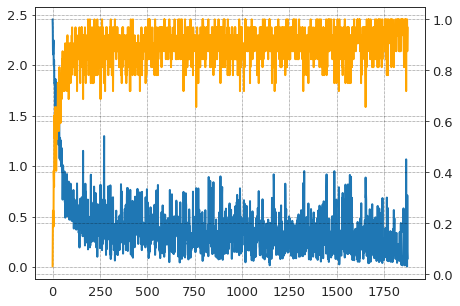

In [30]:
# Backprop on a simple neural network
def relu(x):
    """ReLU non-linearity"""
    return np.maximum(0, x)

def logsumexp(logit):
    """
    Implements the log-sum-exp trick for numerical stability purposes. Based on
    the observation that the log-sum-exp operation is approximately a max function
    """
    # https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    shift = logit.max(axis=1)
    return shift + np.log(np.exp(logit - shift.reshape(-1, 1)).sum(axis=1))

def he_normal(shape, scale=2.0, mode='fan_in', random_state=None, dtype='float32'):
    """
    He Initialization, best used for ReLU and related
    Use 'fan_in' to preserve magnitude of variance in forward pass
    and 'fan_out for backward pass'.
    """
    if random_state:
        np.random.seed(random_state)
    # Number of outputs/neurons
    if mode == 'fan_out':
        fan = shape[-1]
    # Number of inputs
    elif mode == 'fan_in':
        fan = shape[0]
    else:
        raise TypeError
    sigma = np.sqrt(scale/fan)
    return np.random.normal(0, sigma, shape).astype(dtype)

def log_loss(y_true, y_pred):
    """
    Cross entropy loss (nll) between predicted probabilities
    and the true probability distribution of the form
    H(p, q) = (1/m) * \sum_{i=1}^m - p \log(q)
    """
    m = y_pred.shape[0]
    #print(y_pred)
    return (-1/m) * np.sum(y_true * np.log(y_pred))

class OneHotEncoder:
    def __init__(self):
        self.labels = None
    
    def fit(self, y):
        self.labels = np.unique(y)
        return self
    
    def transform(self, y):
        one_hot = np.zeros((y.shape[0], self.labels.size))
        one_hot[np.arange(y.shape[0]), y] = 1
        return one_hot
    
    def fit_transform(self, y):
        self.fit(y)
        return self.transform(y)
        
class Linear:
    def __init__(self, shape):
        self.w = he_normal(shape, random_state=42)
        self.b = np,zeros(shape[-1])
        self.activation = None
        
    def __call__(x):
        return X @ w + b
    
class MLP:
    def __init__(self, layers):
        self.layers = []
    
    def forward_pass(x):
        out = x
        for l in self.layers:
            out = l(out)
        return out
    
def batch_dset(X, y, batch_size=32):
    m = X.shape[0]
    max_step = np.ceil(m / batch_size).astype(int)
    for step in range(1, max_step+1):
        start = (step-1) * batch_size
        stop = step * batch_size
        y_batch = y[start:stop]
        X_batch = X[start:stop]
        yield X_batch, y_batch
        
        
input_shape = 784

y_one_hot = OneHotEncoder().fit_transform(y_train)
X_train_flat = X_train.reshape(-1,784)

def two_layer_nn(x, y, alpha=0.0001, epochs=20, batch_size=32, random_state=None):
    # Init layers and weights
    w1, b1 = he_normal([784, 128], random_state=random_state), np.zeros(128)
    w2, b2 = he_normal([128, 64], random_state=random_state), np.zeros(64)
    w3, b3 = he_normal([64, 10], random_state=random_state), np.zeros(10)
    
    m = x.shape[0]
    steps = np.ceil(m / batch_size).astype(int)
    
    loss_plot = []
    accuracy_plot = []
    for epoch in range(epochs):
        dset = batch_dset(x, y, batch_size=batch_size)
        pbar = tqdm.tqdm(
            dset,
            position=0,
            leave=True,
            desc=f'Epoch {epoch+1}/{epochs}:',
            total=steps
            )
        total_loss = 0
        total_correct = 0
        for step, (X_batch, y_batch) in enumerate(pbar, start=1):
            # Forward and backward pass
            p1 = X_batch @ w1
            s1 = p1 + b1
            a1 = relu(s1)

            p2 = a1 @ w2
            s2 = p2 + b2
            a2 = relu(s2)

            p3 = a2 @ w3
            s3 = p3 + b3
            a3 = s3 - logsumexp(s3).reshape(-1, 1) # logits
            
            probs = np.exp(a3)
            preds = np.argmax(probs, axis=1) 
            y_cat = np.argmax(y_batch, axis=1)

            # Equivalent to the cross entropy loss, calculating from logits instead
            current_loss = ((-y_batch) * a3).mean() * 10
            total_loss += current_loss
            mean_loss = '{:.4f}'.format(total_loss * (1/step))
            
            
            # Accuracy metrics, keep total correct and divide by total examples seen
            current_correct = (preds == y_cat).sum()
            total_correct += current_correct
            current_examples = ((step-1)*batch_size+y_batch.shape[0])
            mean_accuracy = '{:.4f}'.format(total_correct/current_examples)
            
            # For learning plot
            loss_plot.append(current_loss)
            accuracy_plot.append(current_correct/y_batch.shape[0])
            pbar.set_postfix({'Loss' : mean_loss, 'Accuracy': mean_accuracy})
            
            # Backpropagating gradients
            grad_y_batch = (-y_batch) / y_batch.shape[0]
            
            # grad_a3 --> dx_LogSoftmax
            grad_a3 = grad_y_batch - probs * grad_y_batch.sum(axis=1).reshape(-1, 1)
            grad_b3 = grad_a3.sum(axis=0).ravel()
            grad_w3 = a2.T @ grad_a3
            
            grad_a2 = grad_a3 @ w3.T
            grad_b2 = grad_a2.sum(axis=0).ravel()
            grad_w2 = a1.T @ grad_a2
            
            grad_a1 = grad_a2 @ w2.T
            grad_b1 = grad_a1.sum(axis=0).ravel()
            grad_w1 = X_batch.T @ grad_a1

            # GD Step
            w1 -= alpha * grad_w1
            w2 -= alpha * grad_w2
            w3 -= alpha * grad_w3
            
            b1 -= alpha * grad_b1
            b2 -= alpha * grad_b2
            b3 -= alpha * grad_b3

    return loss_plot, accuracy_plot

# Ensure it works with batches
loss, accuracy = two_layer_nn(X_train_flat, y_one_hot, epochs=1, alpha=0.05, random_state=10)
plt.plot(loss)
plt.twinx()
plt.plot(accuracy, color='orange')